# Movie Review Text Classification with Text processing
This tutorial: https://www.tensorflow.org/tutorials/keras/text_classification

In [1]:
!pip install -q tf-nightly
import tensorflow as tf

In [2]:
from tensorflow import keras

!pip install -q tfds-nightly
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np

print(tf.__version__)

2.2.0-dev20200429


In [3]:
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

Shuffling and writing examples to /home/jovyan/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteU1ZVMF/imdb_reviews-train.tfrecord
Shuffling and writing examples to /home/jovyan/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteU1ZVMF/imdb_reviews-test.tfrecord
Shuffling and writing examples to /home/jovyan/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteU1ZVMF/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /home/jovyan/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [5]:
encoder = info.features['text'].encoder

In [6]:
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [7]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

assert original_string == sample_string

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [8]:
for ts in encoded_string:
  print ('{} ----> {}'.format(ts, encoder.decode([ts])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [16]:
for train_example, train_label in train_data.take(5):
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())
  print(encoder.decode(train_example)[:150])

Encoded text: [  62   18   41  604  927   65    3  644 7968   21]
Label: 0
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be the
Encoded text: [  12   31   93  867    7 1256 6585 7961  421  365]
Label: 0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable 
Encoded text: [ 636  102 4714    8    1 4333    4 4135   47 1325]
Label: 0
Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem
Encoded text: [  62    9    1  312    6   32   23    4 7809   47]
Label: 1
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chai
Encoded text: [ 249  929   31 2699  104    2   51    1  707   13]
Label: 1
As others have mentio

In [18]:
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32, padded_shapes=([None],[])))

test_batches = (
    test_data
    .padded_batch(32, padded_shapes=([None],[])))

In [20]:
train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32))

test_batches = (
    test_data
    .padded_batch(32))

In [21]:
for example_batch, label_batch in train_batches.take(2):
  print("Batch shape:", example_batch.shape)
  print("label shape:", label_batch.shape)

Batch shape: (32, 784)
label shape: (32,)
Batch shape: (32, 1179)
label shape: (32,)


In [22]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/10
782/782 [==============================] - 4s 6ms/step - loss: 0.6806 - accuracy: 0.5008 - val_loss: 0.6622 - val_accuracy: 0.5094
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 0.6172 - accuracy: 0.5576 - val_loss: 0.5943 - val_accuracy: 0.5552
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 0.5383 - accuracy: 0.6684 - val_loss: 0.5296 - val_accuracy: 0.7188
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.4714 - accuracy: 0.7542 - val_loss: 0.4801 - val_accuracy: 0.7469
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 0.4196 - accuracy: 0.8043 - val_loss: 0.4447 - val_accuracy: 0.8198
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 0.3780 - accuracy: 0.8350 - val_loss: 0.4168 - val_accuracy: 0.8510
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 0.3482 - accuracy: 0.8557 - val_loss: 0.3959 - val_accuracy: 0.8354
Epoch 

In [25]:
loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 3ms/step - loss: 0.3316 - accuracy: 0.8534
Loss:  0.33159756660461426
Accuracy:  0.8533599972724915


In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

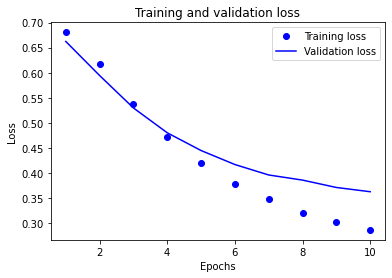

In [27]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

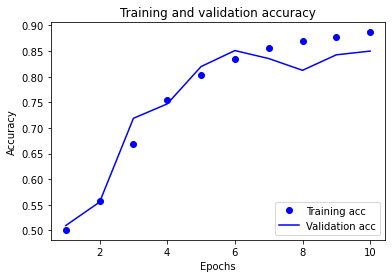

In [28]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [183]:
[(review, label)] = list(test_data.skip(0).take(1))
reviewPredictable = tf.expand_dims(review, 0)
[[prediction]] = model.predict(reviewPredictable)
print('prediction', prediction)
print('actual value', label.numpy())

prediction -2.9700978
actual value 1


I want a binary output, but the prediction is acutally a numeric value with uncertain(?) range. I could use the sigmoid ativation function for the last layer, but that is not recommended because the linear activation function supports 'numerical stability'. How to get the binary propability again?